In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

## Load Dataset

In [2]:
X_train = np.loadtxt('TinyMNIST/trainData.csv', dtype=np.float32, delimiter=',')
y_train = np.loadtxt('TinyMNIST/trainLabels.csv', dtype=np.int32, delimiter=',')

X_test = np.loadtxt('TinyMNIST/testData.csv', dtype=np.float32, delimiter=',')
y_test = np.loadtxt('TinyMNIST/testLabels.csv', dtype=np.int32, delimiter=',')

print(X_train.shape)
print(X_test.shape)

(5000, 196)
(2500, 196)


## Feature Filtering

In [3]:
from sklearn.feature_selection import VarianceThreshold

# Feature Filtering
tr_samples_size, _ = X_train.shape
all_data = np.vstack((X_train, X_test))
sel = VarianceThreshold(threshold=0.90*(1-0.90))
all_data = sel.fit_transform(all_data)
X_train = all_data[:tr_samples_size]
X_test = all_data[tr_samples_size:]

print(X_train.shape)
print(X_test.shape)

(5000, 62)
(2500, 62)


## Classification with Parzen Window

$$
P_{j}( x) =\frac{k_{n}}{nV_{n}} =\frac{1}{n}\sum ^{n}_{i=1}\frac{1}{h^{d}_{j}}\underbrace{\phi \left(\frac{x-x_{i}}{h_{j}}\right)}_{window\ function}
$$


In [4]:
def plot_confusion_matrix(ax, cm, classes,
                          title='Confusion matrix'):
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')

### Parzen with Gaussian Window

$$
\frac{1}{( 2\pi )^{\frac{d}{2}} |\Sigma _{j} |^{\frac{1}{2}}}\exp\left( -\frac{1}{2}\left(\underline{x_{i}} -\underline{\mu _{j}}\right)^{T} \Sigma ^{-1}_{j}\left(\underline{x_{i}} -\underline{\mu _{j}}\right)\right)
$$


In [5]:
def multivariate_normal(mu, sigma, X):
    diff = X - mu[:, np.newaxis]
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)
    g = (np.exp(-(diff.T @ inv_sigma @ diff) / 2)) / (2 * np.pi * np.sqrt(det_sigma))
    return np.diag(g)

In [6]:
def gaussian_parzen(X_train, y_train, X_test, size):
    sigma = size * np.identity(X_train.shape[1])

    y_probs = np.empty((X_test.shape[0], 10))
    for i in range(10):
        X_i = X_train[y_train==i]
        n_i = X_i.shape[0]
        y_i = np.array([multivariate_normal(q, sigma, X_i.T).sum() for q in X_test]) / n_i
        y_probs[:, i] = y_i

    y_pred = y_probs.argmax(axis=1)
    return y_pred

In [7]:
# take time :D (~3 min)
y_pred_1 = gaussian_parzen(X_train, y_train, X_test, 0.25)
y_pred_2 = gaussian_parzen(X_train, y_train, X_test, 0.5)
y_pred_3 = gaussian_parzen(X_train, y_train, X_test, 1)

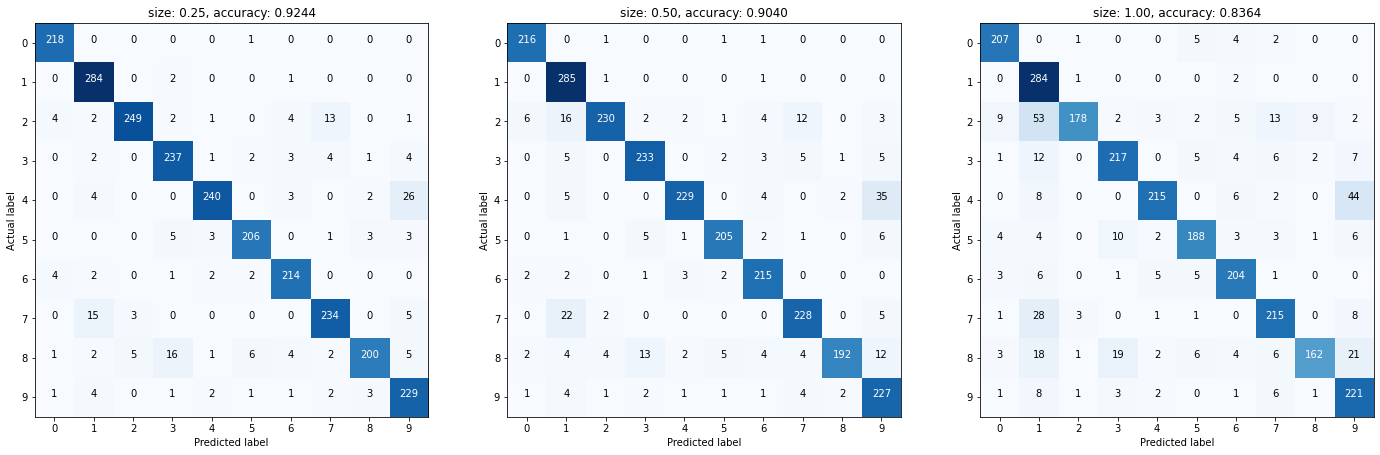

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
classes = range(10)

cm_1 = confusion_matrix(y_test, y_pred_1)
total_acc_1 = accuracy_score(y_test, y_pred_1)
plot_confusion_matrix(axs[0], cm_1, classes, 'size: %0.2f, accuracy: %0.4f' % (0.25, total_acc_1))

cm_2 = confusion_matrix(y_test, y_pred_2)
total_acc_2 = accuracy_score(y_test, y_pred_2)
plot_confusion_matrix(axs[1], cm_2, classes, 'size: %0.2f, accuracy: %0.4f' % (0.5, total_acc_2))

cm_3 = confusion_matrix(y_test, y_pred_3)
total_acc_3 = accuracy_score(y_test, y_pred_3)
plot_confusion_matrix(axs[2], cm_3, classes, 'size: %0.2f, accuracy: %0.4f' % (1, total_acc_3))

### Parzen with Rectangle Window

$$
\begin{cases}
1 & |x_{i} |\leqslant \frac{h}{2} \ for\ all\ i=1,2,\ ...\ ,\ d\\
0 & o.w.
\end{cases}
$$


In [9]:
def box(center, size, X):
    return (np.abs(X - center) <= (size/2)).sum(axis=1) == X.shape[1]

In [10]:
def box_parzen(X_train, y_train, X_test, size):
    y_probs = np.empty((X_test.shape[0], 10))
    for i in range(10):
        X_i = X_train[y_train==i]
        n_i = X_i.shape[0]
        y_i = np.array([box(q, size, X_i).sum() for q in X_test]) / n_i
        y_probs[:, i] = y_i

    y_pred = y_probs.argmax(axis=1)
    return y_pred

In [11]:
# take time :D (~1 min)
y_pred_1 = box_parzen(X_train, y_train, X_test, 1.3)
y_pred_2 = box_parzen(X_train, y_train, X_test, 1.6)
y_pred_3 = box_parzen(X_train, y_train, X_test, 1.9)

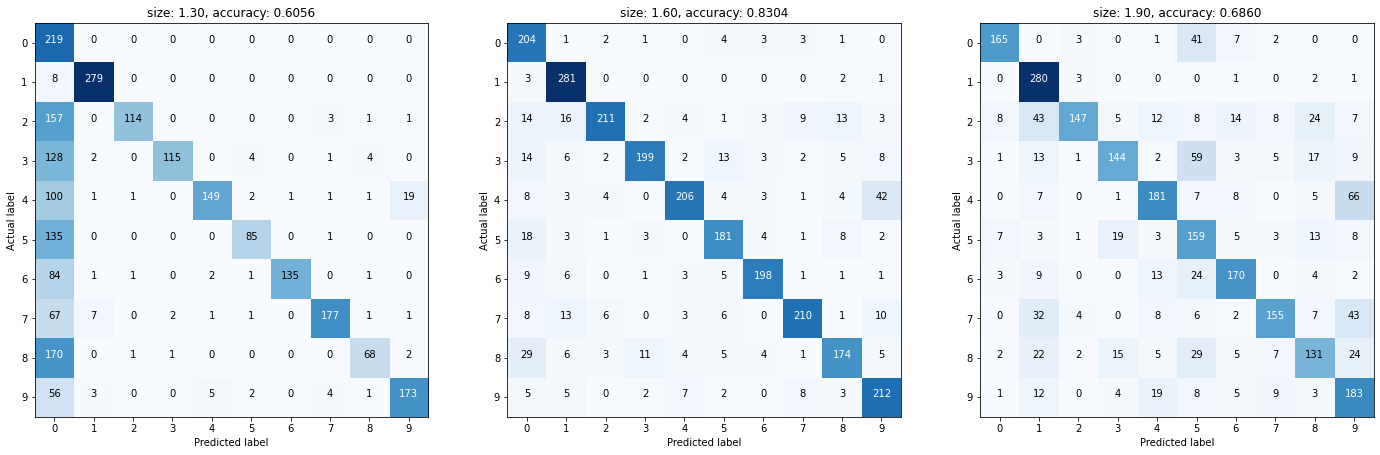

In [12]:
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
classes = range(10)

cm_1 = confusion_matrix(y_test, y_pred_1)
total_acc_1 = accuracy_score(y_test, y_pred_1)
plot_confusion_matrix(axs[0], cm_1, classes, 'size: %0.2f, accuracy: %0.4f' % (1.3, total_acc_1))

cm_2 = confusion_matrix(y_test, y_pred_2)
total_acc_2 = accuracy_score(y_test, y_pred_2)
plot_confusion_matrix(axs[1], cm_2, classes, 'size: %0.2f, accuracy: %0.4f' % (1.6, total_acc_2))

cm_3 = confusion_matrix(y_test, y_pred_3)
total_acc_3 = accuracy_score(y_test, y_pred_3)
plot_confusion_matrix(axs[2], cm_3, classes, 'size: %0.2f, accuracy: %0.4f' % (1.9, total_acc_3))